In [282]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import torch.cuda.amp as amp  

In [283]:
# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [284]:
# Load Dataset
df = pd.read_csv("./fundamentals.csv")
print(df.head())

   Unnamed: 0 Ticker Symbol Period Ending  Accounts Payable  \
0           0           AAL    2012-12-31      3.068000e+09   
1           1           AAL    2013-12-31      4.975000e+09   
2           2           AAL    2014-12-31      4.668000e+09   
3           3           AAL    2015-12-31      5.102000e+09   
4           4           AAP    2012-12-29      2.409453e+09   

   Accounts Receivable  Add'l income/expense items  After Tax ROE  \
0         -222000000.0               -1.961000e+09           23.0   
1          -93000000.0               -2.723000e+09           67.0   
2         -160000000.0               -1.500000e+08          143.0   
3          352000000.0               -7.080000e+08          135.0   
4          -89482000.0                6.000000e+05           32.0   

   Capital Expenditures  Capital Surplus  Cash Ratio  ...  \
0         -1.888000e+09     4.695000e+09        53.0  ...   
1         -3.114000e+09     1.059200e+10        75.0  ...   
2         -5.311000e+09

In [285]:
# Drop non-numeric and unnecessary columns
df = df.select_dtypes(include=[np.number]).drop(columns=['Unnamed: 0']).dropna()

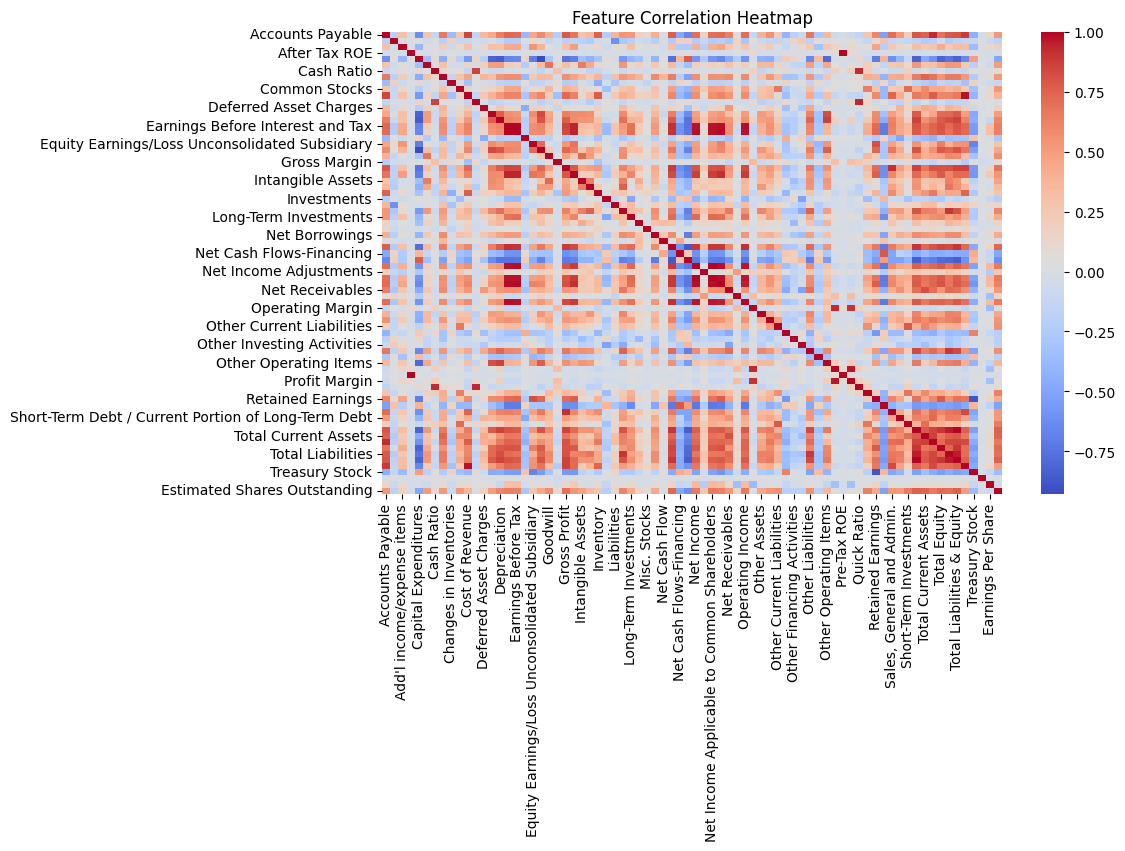

In [286]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

In [287]:
# Check top correlated features again
correlation = df.corr()
top_features = correlation["Earnings Per Share"].abs().sort_values(ascending=False)[1:20].index.tolist()
X = df[top_features]

In [288]:
y = np.log1p(df["Earnings Per Share"] - df["Earnings Per Share"].min() + 1)  # Shift and log transform


In [289]:
# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [290]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [291]:
# Convert to Torch Tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test.values).view(-1, 1).to(device)

In [292]:
# DataLoader for Efficient Mini-Batch Training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [293]:
# ✅ Define Optimized Neural Network with Non-Linearity
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.1),  # More flexible than ReLU
            nn.BatchNorm1d(128), 
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)


In [294]:
# ✅ Train Model with Mixed Precision & Learning Rate Scheduler
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=50):
    model.train()
    scaler = torch.amp.GradScaler()  # Mixed Precision Training
    train_losses, test_losses, train_r2, test_r2 = [], [], [], []

    for epoch in range(epochs):
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            with torch.amp.autocast(device_type='cuda'):
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        # Adjust Learning Rate
        scheduler.step()

        # ✅ Evaluate on Test Set
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor).item()

            # ✅ Convert predictions back to original scale before computing R²
            y_train_actual = np.expm1(y_train_tensor.cpu().numpy().flatten()) + df["Earnings Per Share"].min() - 1
            y_test_actual = np.expm1(y_test_tensor.cpu().numpy().flatten()) + df["Earnings Per Share"].min() - 1
            y_train_pred = np.expm1(model(X_train_tensor).cpu().detach().numpy().flatten()) + df["Earnings Per Share"].min() - 1
            y_test_pred = np.expm1(test_outputs.cpu().detach().numpy().flatten()) + df["Earnings Per Share"].min() - 1

            train_r2.append(r2_score(y_train_actual, y_train_pred))
            test_r2.append(r2_score(y_test_actual, y_test_pred))

        train_losses.append(loss.item())
        test_losses.append(test_loss)

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}, R² Score: {test_r2[-1]:.4f}')

    return train_losses, test_losses, train_r2, test_r2


In [295]:
# ✅ Initialize Model and Optimizer
input_dim = X_train.shape[1]
model = RegressionModel(input_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Lower LR + L2 Regularization
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # Reduce LR every 10 epochs


In [296]:
# ✅ Train Model
train_losses, test_losses, train_r2, test_r2 = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler)


Epoch [10/50], Train Loss: 2.3468, Test Loss: 1.4614, R² Score: -368.1451
Epoch [20/50], Train Loss: 0.0405, Test Loss: 0.2236, R² Score: -30.8569
Epoch [30/50], Train Loss: 0.0103, Test Loss: 0.1354, R² Score: -28.5930
Epoch [40/50], Train Loss: 0.0654, Test Loss: 0.1149, R² Score: -26.3261
Epoch [50/50], Train Loss: 0.0114, Test Loss: 0.1071, R² Score: -19.8167


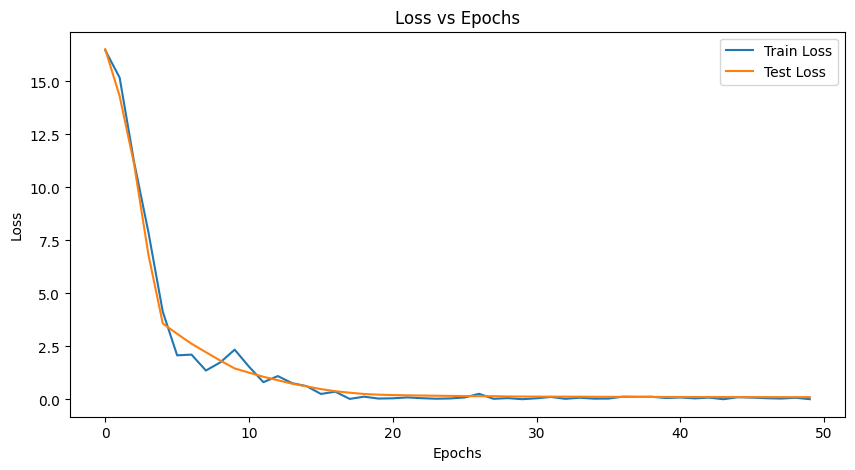

In [297]:
# ✅ Plot Loss vs Epochs
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')
plt.show()


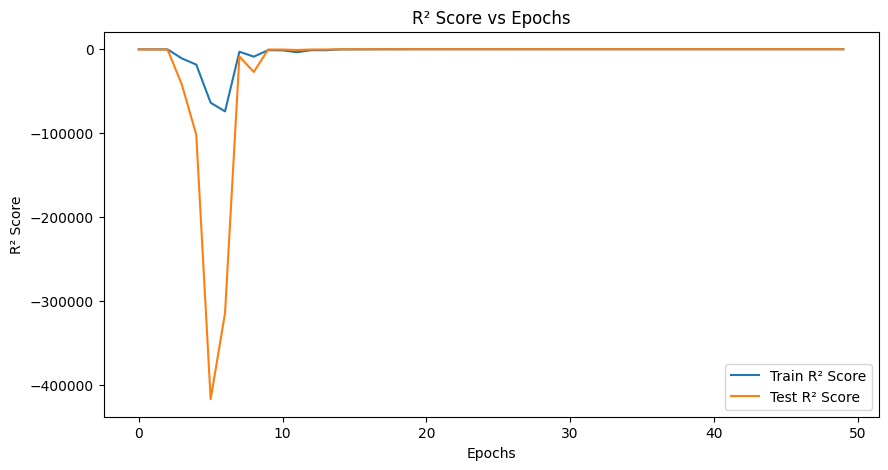

In [298]:
# ✅ Plot R² Score vs Epochs
plt.figure(figsize=(10,5))
plt.plot(train_r2, label='Train R² Score')
plt.plot(test_r2, label='Test R² Score')
plt.xlabel('Epochs')
plt.ylabel('R² Score')
plt.legend()
plt.title('R² Score vs Epochs')
plt.show()